In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

#### Creo un dataset artificiale con un problema di classificazione dove ogni x = a 100 elementi fra 0 e 1 dove la somma delle presenze del numero 1 all 'interno é dato da un numero casuale fra 0 e 8 
#### Y = a un valore tra 0 e 8 


#### Mentre i dati per il test spaziano da 0, 80 

In [3]:
x = np.zeros((1000, 100))
y = np.zeros(1000)

for i in range(1000):
    rand = np.random.randint(0, 8)
    while np.sum(x[i]) < rand:
        rand_2 = np.random.randint(100)
        x[i, rand_2] = 1
    y[i] = rand

x_test = np.zeros((200, 100))
y_test = np.zeros(200)

for i in range(200):
    rand = np.random.randint(0, 80)
    while np.sum(x_test[i]) < rand:
        rand_2 = np.random.randint(100)
        x_test[i, rand_2] = 1
    y_test[i] = rand

#### Provo ad addestrare un modello con un architettura Dense da 16 celle

In [4]:
input = tf.keras.layers.Input(shape=(x.shape[1:]))

dense = tf.keras.layers.Dense(16, activation='relu')(input)
output = tf.keras.layers.Dense(1)(dense)

model = tf.keras.models.Model(
    inputs=input,
    outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError()
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1633 (6.38 KB)
Trainable params: 1633 (6.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


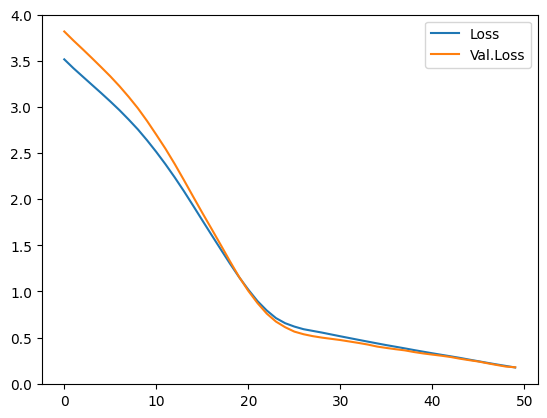

---------------------------------
LOSSES
train      0.17565369606018066
validation 0.17779235541820526
test       2.843972682952881


In [5]:
def train_and_test():
    history = model.fit(
        x=x[:900],
        y=y[:900],
        validation_data=(x[900:], y[900:]),
        batch_size=128,
        verbose=0,
        epochs=50
    )

    test_results = model.evaluate(x_test, y_test, verbose=0, batch_size=128)

    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val.Loss')
    plt.legend()
    plt.show()

    print('---------------------------------')
    print('LOSSES')
    print('train     ', history.history['loss'][-1])
    print('validation', history.history['val_loss'][-1])
    print('test      ', test_results)

train_and_test()

#### Come possiamo vedere il modello non riesce a generalizzare data la differenza di valori tra i dati di addestramento e i dati di test

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2177 (8.50 KB)
Trainable params: 2177 (8.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


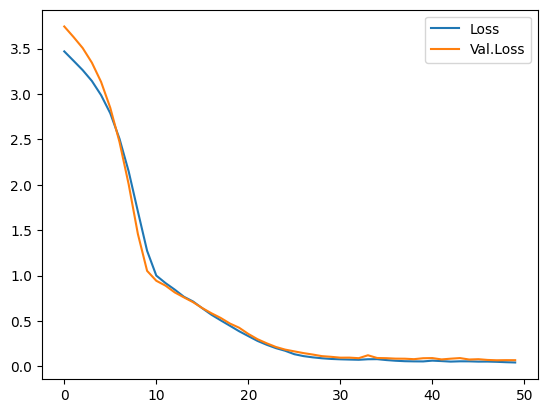

---------------------------------
LOSSES
train      0.04355737566947937
validation 0.06873918324708939
test       0.4580434560775757


In [6]:
input = tf.keras.layers.Input(shape=(x.shape[1:]))

dense = tf.keras.layers.Dense(16, activation='relu')(input)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
output = tf.keras.layers.Dense(1)(dense)

model = tf.keras.models.Model(
    inputs=input,
    outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError()
)

model.summary()

train_and_test()

#### Stessa cosa per un architettura con celle LSTM

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 100, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


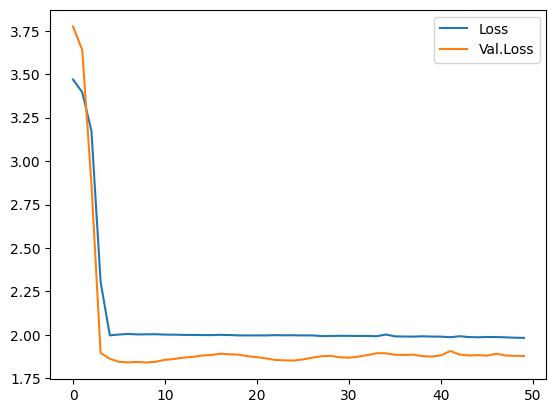

---------------------------------
LOSSES
train      1.98264741897583
validation 1.8783023357391357
test       36.52460479736328


In [7]:
input = tf.keras.layers.Input(shape=(x.shape[1:]))
reshaping = tf.keras.layers.Reshape((x.shape[1], 1))(input)
dense = tf.keras.layers.LSTM(32)(reshaping)
output = tf.keras.layers.Dense(1)(dense)

model = tf.keras.models.Model(
    inputs=input,
    outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError()
)

model.summary()

train_and_test()

#### Implementazione di un modello NAC 
* La funzione __init__ (Costruttore) lo utilizzo per definire i pesi
  l'inizializzazione tramite una glorot uniform (Pesi casuali ma uniformi)
  Nessuna regolarizzazione
  Nessuna restrizione

* La build che procediamo a inizializzare i pesi pre costruiti
  
* La call procediamo alla moltiplicazione fra i pesi dell faunzione sigmoide e tangente iperbolica

* La compute_output_shape definiamo l'output di uscita

* La get_config creo un dizionario con la configurazione dei pesi

In [9]:
class NAC(tf.keras.layers.Layer):
    def __init__(self, units, 
                 kernel_W_initializer = 'glorot_uniform',
                 kernel_M_initializer = 'glorot_uniform',
                 kernel_W_regularizer = None,
                 kernel_M_regularizer = None,
                 kernel_W_constraint=None,
                 kernel_M_constraint=None,
                 **kwargs):
        super(NAC, self).__init__()
        self.units = units

        self.kernel_W_initializer = tf.keras.initializers.get(kernel_W_initializer)
        self.kernel_M_initializer = tf.keras.initializers.get(kernel_M_initializer)
        self.kernel_W_regularizer = tf.keras.regularizers.get(kernel_W_regularizer)
        self.kernel_M_regularizer = tf.keras.regularizers.get(kernel_M_regularizer)
        self.kernel_W_constraint = tf.keras.constraints.get(kernel_W_constraint)
        self.kernel_M_constraint = tf.keras.constraints.get(kernel_M_constraint)

        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.W_hat = self.add_weight(shape=(input_dim, self.units),
                                     name='W_hat',
                                     initializer=self.kernel_W_initializer,
                                     regularizer=self.kernel_W_regularizer,
                                     constraint=self.kernel_W_constraint)

        self.M_hat = self.add_weight(shape=(input_dim, self.units),
                                     name='M_hat',
                                     initializer=self.kernel_M_initializer,
                                     regularizer=self.kernel_M_regularizer,
                                     constraint=self.kernel_M_constraint)

        self.input_spec = tf.keras.layers.InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs, **kwargs):
        W = tf.keras.backend.tanh(self.W_hat) * tf.keras.backend.sigmoid(self.M_hat)
        a = tf.keras.backend.dot(inputs, W)
        return a 

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'kernel_W_initializer': tf.keras.initializers.serialize(self.kernel_W_initializer),
            'kernel_M_initializer': tf.keras.initializers.serialize(self.kernel_M_initializer),
            'kernel_W_regularizer': tf.keras.regularizers.serialize(self.kernel_W_regularizer),
            'kernel_M_regularizer': tf.keras.regularizers.serialize(self.kernel_M_regularizer),
            'kernel_W_constraint': tf.keras.constraints.serialize(self.kernel_W_constraint),
            'kernel_M_constraint': tf.keras.constraints.serialize(self.kernel_M_constraint),
        }

        base_config = super(NAC, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

tf.keras.utils.get_custom_objects().update({'NAC': NAC})
        

#### Grazie alla NAC il modello é riuscito a generalizzare e a portare un ottimo risultato in fase di test cosa che altri modello principalmente non lineari non riescono a fare 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 nac (NAC)                   (None, 16)                3200      
                                                                 
 nac_1 (NAC)                 (None, 16)                512       
                                                                 
 nac_2 (NAC)                 (None, 16)                512       
                                                                 
 nac_3 (NAC)                 (None, 1)                 32        
                                                                 
Total params: 4256 (16.62 KB)
Trainable params: 4256 (16.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


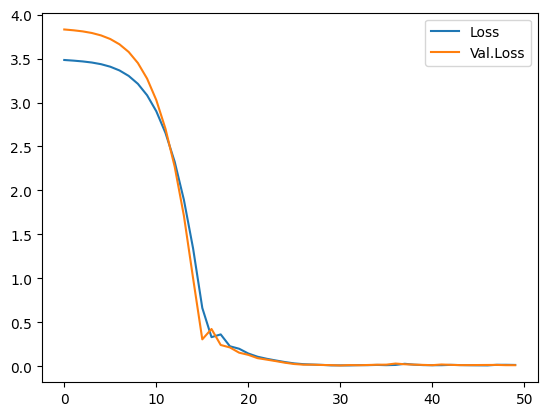

---------------------------------
LOSSES
train      0.016345111653208733
validation 0.013463067822158337
test       0.04147263616323471


In [10]:
input = tf.keras.layers.Input(shape=(x.shape[1:]))

dense = NAC(16)(input)
dense = NAC(16)(dense)
dense = NAC(16)(dense)
output = NAC(1)(dense)

model = tf.keras.models.Model(
    inputs=input,
    outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError()
)

model.summary()

train_and_test()